<a href="https://colab.research.google.com/github/tekky02/learn_cv/blob/master/styletransfer_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 代码参考tensorflow官方指南：https://tensorflow.google.cn/tutorials/generative/style_transfer?hl=zh-cn

### 在google colab平台执行

In [7]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        
    plt.imshow(image)
    if title:
        plt.title(title)

In [3]:
import io

from PIL import Image
import requests

def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

In [19]:
# download image from github

download_image('https://github.com/tekky02/learn_cv/blob/master/img_4.jpg?raw=true', 'img_4.jpg')
download_image('https://github.com/tekky02/learn_cv/blob/master/style_2.jpg?raw=true', 'style_2.jpg')

Image downloaded from url: https://github.com/tekky02/learn_cv/blob/master/img_4.jpg?raw=true and saved to: img_4.jpg.
Image downloaded from url: https://github.com/tekky02/learn_cv/blob/master/style_2.jpg?raw=true and saved to: style_2.jpg.


In [20]:
content_path = 'img_4.jpg'
style_path = 'style_2.jpg'

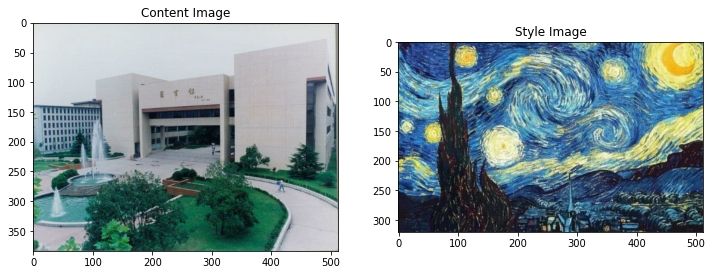

In [21]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [23]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# 内容层将提取出我们的 feature maps （特征图）
content_layers = ['block5_conv2'] 

# 我们感兴趣的风格层
style_layers = ['block1_conv1',
         'block2_conv1',
         'block3_conv1', 
         'block4_conv1', 
         'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [24]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # 加载我们的模型。 加载已经在 imagenet 数据上预训练的 VGG 
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [25]:
# 建立模型
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#查看每层输出的统计信息
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 320, 512, 64)
  min:  0.0
  max:  802.1941
  mean:  28.745045

block2_conv1
  shape:  (1, 160, 256, 128)
  min:  0.0
  max:  3468.566
  mean:  177.73068

block3_conv1
  shape:  (1, 80, 128, 256)
  min:  0.0
  max:  8726.55
  mean:  173.903

block4_conv1
  shape:  (1, 40, 64, 512)
  min:  0.0
  max:  17339.715
  mean:  658.33374

block5_conv1
  shape:  (1, 20, 32, 512)
  min:  0.0
  max:  3420.1995
  mean:  55.191723



In [26]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [27]:
# 构建一个返回风格和内容张量的模型。
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [28]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.007534548
    max:  43728.8
    mean:  505.93915

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  79177.26
    mean:  14215.697

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  419180.25
    mean:  13275.277

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4520227.5
    mean:  192076.56

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  76836.164
    mean:  1323.6582

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  976.2043
    mean:  13.626297


In [29]:
# 设置风格和内容的目标值
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# 要优化的图像
image = tf.Variable(content_image)

# 归一化
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.2, beta_1=0.99, epsilon=1e-1)

# 损失加权
style_weight = 1e-2
content_weight = 1e4

In [30]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [31]:
# 使用tf.GradientTape更新图像
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

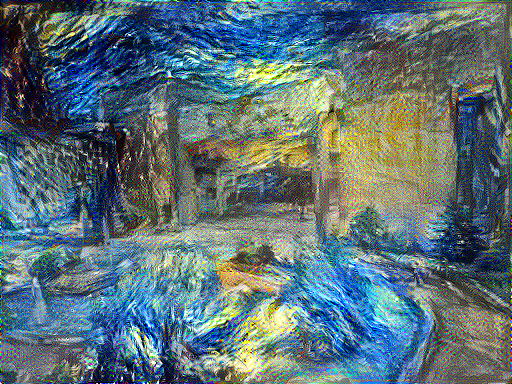

Train step: 2000
Total time: 132.1


In [33]:
import time
start = time.time()

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))